In [76]:
#!pip3 install leidenalg
#!pip3 install pyranges
#!pip3 install pyBigWig
#!pip3 install ray
#!pip3 install lda
#!pip3 install tmtoolkit
#!python -m pip install -U gensim
#%cd pycisTopic
#%ls
#%cd ..
#!git clone https://github.com/aertslab/pycisTopic.git
#%cd pycisTopic
#print(os.listdir())
#!pip install -e .

cistopic_class.py          label_transfer.py           qc.py
clust_vis.py               lda_models.py               signature_enrichment.py
diff_features.py           loom.py                     topic_binarization.py
gene_activity.py           pseudobulk_peak_calling.py  topic_qc.py
__init__.py                __pycache__/                utils.py
iterative_peak_calling.py  pyGREAT.py
/data01/SingleCell/Python_notebooks/pycisTopic
Obtaining file:///data01/SingleCell/Python_notebooks/pycisTopic
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/aertslab/pySCENIC (to revision master) to /tmp/pip-install-20k0kuo2/pyscenic_3b7ea7a30e0f4db2a560877a84a47256
  Running command git clone --filter=blob:none --quiet https://github.com/aertslab/pySCENIC /tmp/pip-install-20k0kuo2/pyscenic_3b7ea7a30e0f4db2a560877a84a47256
  Resolved https://github.com/aertslab/pySCENIC to commit 0a90cb5ca615c633b2e012a992669f784e98bc8b
  Preparing metadata (setup.py) ... done
  Cloning https://githu

  Attempting uninstall: pycisTopic
    Found existing installation: pycisTopic 1.0.2.dev12+g1e354e6
    Uninstalling pycisTopic-1.0.2.dev12+g1e354e6:
      Successfully uninstalled pycisTopic-1.0.2.dev12+g1e354e6
  Running setup.py develop for pycisTopic


In [41]:
import sys
print(sys.version)
!python --version

3.6.4 (default, Sep 25 2020, 13:18:17) 
[GCC 7.5.0]
Python 3.8.0


In [42]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [6]:
!mkdir -p pbmc_tutorial/data
!wget -O pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5 https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
!wget -O pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz

--2023-01-16 14:33:51--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38844318 (37M) [binary/octet-stream]
Saving to: ‘pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’

pbmc_tutorial/data/ 100%[===================>]  37.04M  7.10MB/s    in 5.0s    

2023-01-16 14:33:57 (7.36 MB/s) - ‘pbmc_tutorial/data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’ saved [38844318/38844318]

--2023-01-16 14:33:57--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812

In [43]:
import os
work_dir = 'pbmc_tutorial'

In [44]:
import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))

In [45]:
adata = sc.read_10x_h5(os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5'))
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2711 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [46]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


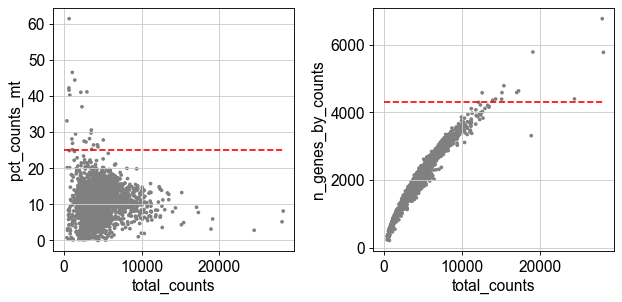

In [47]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()


In [48]:
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
adata

View of AnnData object with n_obs × n_vars = 2664 × 21255
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [49]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/home/prakki/sw/pyenv/versions/3.6.4/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:845: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [50]:
adata_ref = sc.datasets.pbmc3k_processed() #use the preprocessed data from the Scanpy tutorial as reference
var_names = adata_ref.var_names.intersection(adata.var_names) #use genes which are present in both assays
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]
sc.pp.pca(adata_ref) #calculate PCA embedding
sc.pp.neighbors(adata_ref) #calculate neighborhood graph
sc.tl.umap(adata_ref) #calculate umap embedding
sc.tl.ingest(adata, adata_ref, obs='louvain') #run label transfer
adata.obs.rename({'louvain': 'ingest_celltype_label'}, inplace = True, axis = 1)

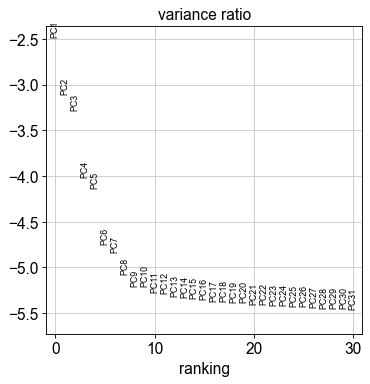

In [51]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

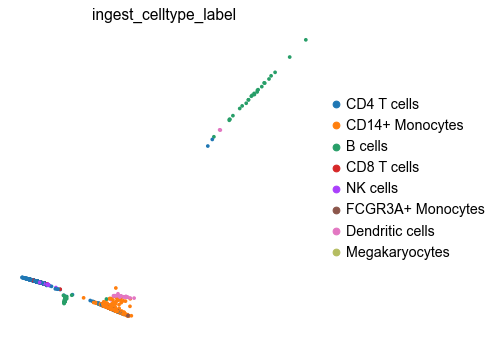

In [52]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'ingest_celltype_label')

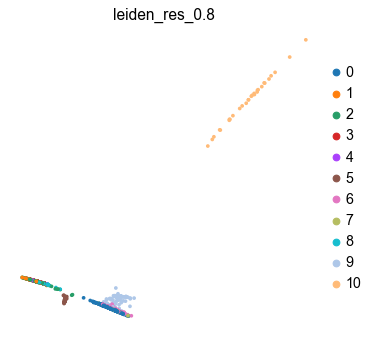

In [53]:
sc.tl.leiden(adata, resolution = 0.8, key_added = 'leiden_res_0.8')
sc.pl.umap(adata, color = 'leiden_res_0.8')

In [54]:
tmp_df = adata.obs.groupby(['leiden_res_0.8', 'ingest_celltype_label']).size().unstack(fill_value=0)
tmp_df = (tmp_df / tmp_df.sum(0)).fillna(0)
leiden_to_annotation = tmp_df.idxmax(1).to_dict()
leiden_to_annotation

{'0': 'CD14+ Monocytes',
 '1': 'CD4 T cells',
 '2': 'CD4 T cells',
 '3': 'CD4 T cells',
 '4': 'CD8 T cells',
 '5': 'B cells',
 '6': 'CD14+ Monocytes',
 '7': 'FCGR3A+ Monocytes',
 '8': 'NK cells',
 '9': 'Dendritic cells',
 '10': 'B cells'}

In [55]:
leiden_to_annotation['7'] = 'B cells 1'
leiden_to_annotation['11'] = 'B cells 2'
leiden_to_annotation = {cluster: leiden_to_annotation[cluster].replace(' ', '_') for cluster in leiden_to_annotation.keys()}
leiden_to_annotation

{'0': 'CD14+_Monocytes',
 '1': 'CD4_T_cells',
 '2': 'CD4_T_cells',
 '3': 'CD4_T_cells',
 '4': 'CD8_T_cells',
 '5': 'B_cells',
 '6': 'CD14+_Monocytes',
 '7': 'B_cells_1',
 '8': 'NK_cells',
 '9': 'Dendritic_cells',
 '10': 'B_cells',
 '11': 'B_cells_2'}

In [56]:
adata.obs['celltype'] = [leiden_to_annotation[cluster_id] for cluster_id in adata.obs['leiden_res_0.8']]
del(leiden_to_annotation)
del(tmp_df)

... storing 'celltype' as categorical


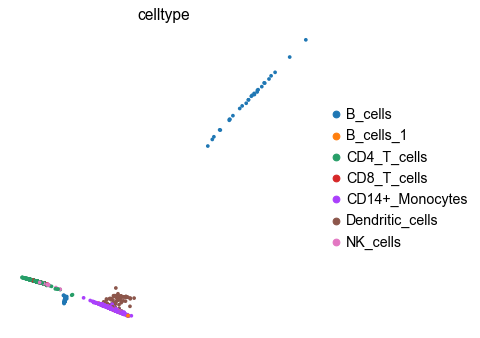

In [57]:
sc.pl.umap(adata, color = 'celltype')

In [58]:
adata.write(os.path.join(work_dir, 'scRNA/adata.h5ad'), compression='gzip')

ATAC data

In [79]:
import os
work_dir = 'pbmc_tutorial'
import pycisTopic
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))
tmp_dir = '/scratch/leuven/330/vsc33053/'


In [80]:
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}


In [87]:
print(work_dir)
print(os.listdir())
%cd /data01/SingleCell/Python_notebooks

pbmc_tutorial
['data', 'pbmc_tutorial', 'SC_Analysis_v1.ipynb', 'pycisTopic', 'scenic+.ipynb', '.ipynb_checkpoints']
/data01/SingleCell/Python_notebooks


In [88]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [89]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [104]:
#Little tests

#import pycisTopic as pT
#help(pycisTopic)
#'pT' in sys.modules
'pycisTopic' in sys.modules
import pycisTopic
pycisTopic.__version__

AttributeError: module 'pycisTopic' has no attribute '__version__'

In [103]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

ModuleNotFoundError: No module named 'pycisTopic.pseudobulk_peak_calling'

In [ ]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [68]:
import pickle
bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=8,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

FileNotFoundError: [Errno 2] No such file or directory: 'pbmc_tutorial/scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'

In [100]:
!pip freeze 

adjustText==0.7.3
aiohttp==3.8.3
aiohttp-cors==0.7.0
aiosignal==1.3.1
alabaster==0.7.12
anndata==0.8.0
annoy==1.17.1
ansiwrap==0.8.4
appdirs==1.4.4
arboreto==0.1.6
asttokens==2.2.1
async-timeout==4.0.2
attr==0.3.2
attrs==22.2.0
Babel==2.11.0
backcall==0.2.0
backports.zoneinfo==0.2.1
bbknn==1.5.1
beautifulsoup4==4.11.1
bioservices==1.11.0
bleach==5.0.1
blessed==1.19.1
blosc2==2.0.0
bokeh==2.4.3
boltons==21.0.0
bs4==0.0.1
cachetools==5.2.0
cattrs==22.2.0
certifi==2022.12.7
cffi==1.15.1
charset-normalizer==2.1.1
click==8.1.3
cloudpickle==2.2.0
colorama==0.4.6
colorful==0.5.5
colorlog==6.7.0
comm==0.1.2
contourpy==1.0.6
cryptography==38.0.4
ctxcore==0.2.0
cycler==0.11.0
Cython==0.29.32
cytoolz==0.12.1
dask==2022.12.1
dataclasses-json==0.5.7
debugpy==1.6.4
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.6
distlib==0.3.6
distributed==2022.12.1
docutils==0.17.1
easydev==0.12.0
entrypoints==0.4
et-xmlfile==1.1.0
exceptiongroup==1.1.0
executing==1.2.0
fa2==0.3.5
fastjsonschema==2.16.2
fbpca==1.0
f